In [102]:
import os
import numpy as np
from scipy import constants as const 
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis.dielectric import DielectricConstant
# import mdtraj as md

def get_volumes(path):
    """read grepped output from CHARMM log file and return list of volumes"""
    with open(path) as f:
        _ = f.readlines()
        return np.array([float(x.split()[-1]) for x in _])*1E-27 #convert to M^3
    
    
def density(volume, N_res, MW):
    """return the density of a pure liquid"""
    return N_res*MW / (const.N_A*volume)
    

In [332]:
_path = "/home/boittier/Documents/PhD/data/methanol/charmm/pressure.raw"

# mdcm
_path2 = "/home/boittier/Documents/PhD/data/methanol/mdcm/ntp/pressure.raw"

_path2 = "/home/boittier/data/param/methanol/fmdcm/r1/t300/pressure.raw"

        
volumes = get_volumes(_path)
volumes = volumes[100:]


In [340]:
volumes2 = get_volumes(_path2)
volumes2 = volumes2[2000:]

# Calculation of Density

Units


In [341]:
avg_vol = np.average(volumes) # 
avg_vol2 = np.average(volumes2) # 
print("avg_vol: ", avg_vol)
N_res = 202 
MW = 32.04 # g/mol
print("density:", density(avg_vol, N_res, MW))

avg_vol:  1.4268288365160763e-23
density: 753.2187050631858


In [342]:
print("density:", density(avg_vol2, N_res, MW))

density: 748.2484016102139


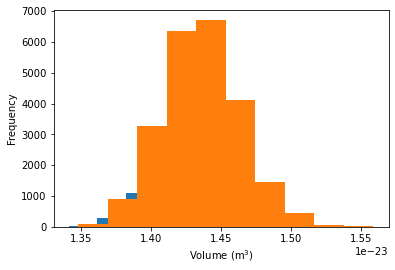

In [343]:
_ = plt.hist(volumes)
plt.xlabel("Volume (m$^{3}$)")
plt.ylabel("Frequency")
plt.savefig("volumes.pdf", bbox_inches="tight")
_ = plt.hist(volumes2)
plt.xlabel("Volume (m$^{3}$)")
plt.ylabel("Frequency")
plt.savefig("volumes.pdf", bbox_inches="tight")

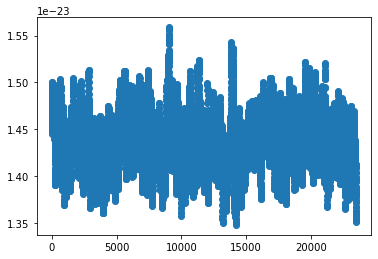

In [344]:
plt.scatter(range(len(volumes2)), volumes2)

#  Dipole moment

## From a Gaussian09 calculation

In [66]:
# Bohr_to_D = 2.541746
# gaussian = np.array([0.5133515,-0.2995578,-0.3396115])/Bohr_to_D
# distance = np.sqrt(np.sum(gaussian**2))
# D = distance
# D
1.79, "D"

(1.79, 'D')

## Gas Phase CHARMM MD Simulation

In [275]:
def dipole(positions, masses, charges, verbose=False):
    """calculate dipole"""
    
    mass_total = masses.sum()
    NATOMS = len(masses)
    masses_tile = np.tile(masses, (3, 1)).T
    charges_tile = np.tile(charges, (3, 1)).T

    pos_x_mass = positions*masses_tile
    CoM = pos_x_mass.sum(axis=0)/mass_total
    
    CoM_tile = np.tile(COM, (NATOMS, 1))
    
    DIF = positions - COM_tile
    moments = (DIF*charges_tile).sum(axis=0)
    magnitude = np.sqrt(np.sum(moments**2))
    
    # print(masses_tile)
    # print(positions)
    # print(moments)
    # print(magnitude)
    # print(DIF)
    # print(DIF*CHARGES_tile)
    # print()
    # print(CHARGES_tile)
    # print(CoM_tile)
    # print(pos_x_mass)
    
    return magnitude
    
dipole(positions, masses, charges)

0.5075931374448444

In [212]:
path = "/home/boittier/Documents/PhD/data/methanol/charmm/vac"
pdb = os.path.join(path, "step4_equilibration.pdb")
psf = os.path.join(path, "ligandrm.psf")
dcd = os.path.join(path, "step4.dcd")
u = mda.Universe(psf, dcd)

In [282]:
dipole_moments = []
timesteps = []
verbose = False

for t, ts in enumerate(u.trajectory):

    masses = u.atoms[:].masses
    charges = u.atoms[:].charges
    positions = u.atoms[:].positions
    magnitude = dipole(positions, masses, charges, verbose=verbose)
    
    dipole_moments.append(magnitude)
    timesteps.append(t)
    

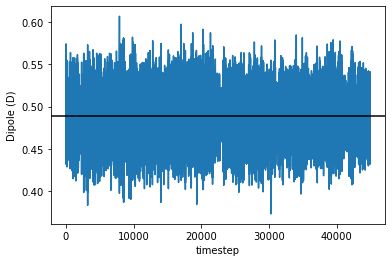

In [283]:
dipole_moments = np.array(dipole_moments)
plt.plot(timesteps, dipole_moments)
plt.axhline(np.mean(dipole_moments), color="k")
plt.xlabel("timestep")
plt.ylabel("Dipole (D)")
plt.savefig("PC_charmm_dipole.pdf", bbox_inches="tight")

In [162]:
xyz_str = """1.4170   -0.0000    0.0040  
 0.0030    0.0010    0.0040
 1.7320    0.9060   -0.0130
-0.3140   -1.0590   -0.0990
-0.3150    0.5870    0.8930
-0.4180    0.4890   -0.9010"""

xyz_ = np.array([[float(x) for x in l.split()] for l in xyz_str.split("\n")])
print(xyz_)

COM_ = xyz_.mean(axis=0)

print(COM)

dcm_str = """2.0004    0.8421   -0.0118   -0.0808
 1.7545    0.9405   -0.0136    0.4371
 1.6476   -0.0774   -0.1762   -0.9912
 1.6476   -0.0705    0.1870   -0.9912
 1.9098    0.0119    0.0038    0.7062
 1.3462   -0.1576    0.0070    0.9250
 0.0468    0.1116    0.0019   -0.2755
-0.3511    0.6606    0.9706    0.0897
-0.4632    0.5539   -0.9815    0.0897
-0.3361   -1.2410   -0.1169    0.0911"""

dcm_ = np.array([[float(x) for x in l.split()] for l in dcm_str.split("\n")])
print(dcm_)


[[ 1.417e+00 -0.000e+00  4.000e-03]
 [ 3.000e-03  1.000e-03  4.000e-03]
 [ 1.732e+00  9.060e-01 -1.300e-02]
 [-3.140e-01 -1.059e+00 -9.900e-02]
 [-3.150e-01  5.870e-01  8.930e-01]
 [-4.180e-01  4.890e-01 -9.010e-01]]
[1.0002534  0.3345685  0.14044471]
[[ 2.0004e+00  8.4210e-01 -1.1800e-02 -8.0800e-02]
 [ 1.7545e+00  9.4050e-01 -1.3600e-02  4.3710e-01]
 [ 1.6476e+00 -7.7400e-02 -1.7620e-01 -9.9120e-01]
 [ 1.6476e+00 -7.0500e-02  1.8700e-01 -9.9120e-01]
 [ 1.9098e+00  1.1900e-02  3.8000e-03  7.0620e-01]
 [ 1.3462e+00 -1.5760e-01  7.0000e-03  9.2500e-01]
 [ 4.6800e-02  1.1160e-01  1.9000e-03 -2.7550e-01]
 [-3.5110e-01  6.6060e-01  9.7060e-01  8.9700e-02]
 [-4.6320e-01  5.5390e-01 -9.8150e-01  8.9700e-02]
 [-3.3610e-01 -1.2410e+00 -1.1690e-01  9.1100e-02]]


##  Liquid phase MDCM

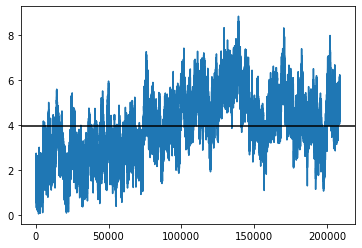

In [318]:
path = "/home/boittier/Documents/PhD/data/methanol/mdcm/dipole/dipole.dat"
with open(path) as f:
    lines = f.readlines()
    
dipole_vec = [[float(_) for _ in x.split()] for x in lines]
dipole_vec = np.array(dipole_vec)
dipole_mag = np.sqrt((dipole_vec**2).sum(axis=1))
timesteps = range(len(dipole_mag))

plt.plot(timesteps, dipole_mag)
plt.axhline(np.mean(dipole_mag), color="k")
# plt.hist(dipole_mag)

In [319]:
print(np.mean(dipole_mag))

3.9734736506094523


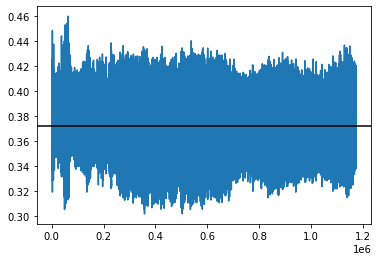

In [327]:
#  done at 400 K...

path = "/home/boittier/Documents/PhD/data/methanol/mdcm/dipole/dipvac.dat"

with open(path) as f:
    lines = f.readlines()
    
dipole_vec = [[float(_) for _ in x.split()] for x in lines]
dipole_vec = np.array(dipole_vec)
dipole_mag = np.sqrt((dipole_vec**2).sum(axis=1))
timesteps = range(len(dipole_mag))

plt.plot(timesteps, dipole_mag)
plt.axhline(np.mean(dipole_mag), color="k")


In [300]:
dipole_mag[0]

0.3811827936830307

#  fMDCM gas phase dipole 

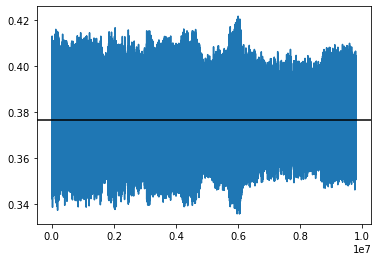

In [325]:
path = "/home/boittier/Documents/PhD/data/methanol/fdcm/dipole/dipvac.dat"

with open(path) as f:
    lines = f.readlines()
    
dipole_vec = [[float(_) for _ in x.split()] for x in lines]
dipole_vec = np.array(dipole_vec)
dipole_mag = np.sqrt((dipole_vec**2).sum(axis=1))
timesteps = range(len(dipole_mag))

plt.plot(timesteps, dipole_mag)
plt.axhline(np.mean(dipole_mag), color="k")